# GPN Intelligence CUP
## Продвинутая аналитика

### Выполнил Никифоров Глеб Владиславович

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score, mean_absolute_error

И подготовленные в ноутбуке 1_Data_Preparing данные

In [4]:
train_data = pd.read_csv('train_data.csv', index_col=0)
prediction_data = pd.read_csv('prediction_data.csv', index_col=0)

Некоторые **важные** значения из предыдущего ноутбука

In [5]:
volume_mean = 3527.3506493506493
volume_std = 3474.835510849148

In [6]:
price_mean = 1.5981150052361002
price_std = 0.6408107188388122

In [7]:
category_dictionary = {'ira': ('AC', 'MN', 'PB'),
 'product_category': ('Chocolates', 'Lollipops'),
 'brand': ('Cadbury', 'Chupa Chups', 'Ferrero Rocher', 'Milka', 'Snickers', 'Toblerone', 'Twix'),
 'sku_id': ('sku #100', 'sku #105', 'sku #106', 'sku #11', 'sku #15', 'sku #16', 'sku #17', 'sku #22', 'sku #25',
  'sku #27', 'sku #28', 'sku #3', 'sku #30', 'sku #31', 'sku #33', 'sku #34', 'sku #37', 'sku #38', 'sku #41',
  'sku #42', 'sku #43', 'sku #44', 'sku #46', 'sku #48', 'sku #49', 'sku #5', 'sku #55', 'sku #60', 'sku #67',
  'sku #7', 'sku #72', 'sku #73', 'sku #76', 'sku #77', 'sku #78', 'sku #79', 'sku #81', 'sku #82', 'sku #83',
  'sku #84', 'sku #94', 'sku #97', 'sku #98'),
 'item_per_bundle': (1, 2, 3),
 'shape': ('Round', 'Square', 'Standart'),
 'with_alcohol': ('No', 'Yes'),
 'filling': ('Berries', 'Nothing', 'Nuts')}

In [8]:
locations = {'AC': 'Alpha City', 'MN': 'Moon', 'PB': 'Pirate Bay'}

В качестве модели опять будем использовать регрессор из библиотеки **XGboost**.

Подготовим все необходимое для обучения.

In [9]:
y = train_data.volume * volume_std + volume_mean
X = train_data.drop(columns=['volume'])

In [10]:
X_to_pred = prediction_data.drop(columns=['volume'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

Введем обозначенную в задании метрику

In [12]:
def SMAPE(y_true, y_pred):
    smape = 100 * (2 * abs(y_pred - y_true) / (abs(y_pred) + abs(y_true))).mean()
    return smape

In [13]:
smape = make_scorer(SMAPE, greater_is_better=False)

и среднюю относительную ошибку

In [14]:
def MRE(y_true, y_pred):
    return (abs(y_pred - y_true) / y_true).mean()

**Подготовим и обучим модель**

In [15]:
regr = xgb.XGBRegressor()

In [16]:
parameters = {'learning_rate': [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.6],
              'verbosity': range(0, 4),
              'booster': ['gbtree', 'gblinear'],
              'max_depth': range(4, 15), 'min_samples_split': range(50, 500, 15),
              'min_samples_leaf': range(50, 500, 10),
              'n_estimators': range(50, 1000, 15)}

Следующий шаг в угоду точности выполняется **очень** долго. Если время принципиально, можно убавить количество итераций или варьируемых параметров, но тогда можно потерять в точности.

In [17]:
rand_search_cv = RandomizedSearchCV(regr, parameters, cv=5, scoring=smape,
                                    n_iter=150, n_jobs=-1, random_state=1)

In [18]:
rand_search_cv.fit(X_train, y_train)

/home/gleb/.local/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:linear',
                                          random_st...
                   param_distributions={'booster': ['gbtree', 'gblinear'],
                                        'learning_rate': [0.001, 0.005, 0.01,
                                    

In [19]:
rand_search_cv.best_params_

{'verbosity': 0,
 'n_estimators': 170,
 'min_samples_split': 455,
 'min_samples_leaf': 120,
 'max_depth': 12,
 'learning_rate': 0.1,
 'booster': 'gbtree'}

In [20]:
xgb_best = rand_search_cv.best_estimator_

In [21]:
y_pred = xgb_best.predict(X_test)

Проведем оценку точности нашей модели.

In [22]:
score = pd.DataFrame()
score['XGBRegressor'] = [SMAPE(y_test, y_pred),
                             mean_absolute_error(y_test, y_pred),
                             MRE(y_test, y_pred),
                             r2_score(y_test, y_pred)]
score.index = ['SMAPE', 'MAE', 'MRE', 'R2']
score

,XGBRegressor
SMAPE,25.933250
MAE,617.073877
MRE,0.447551
R2,0.869154


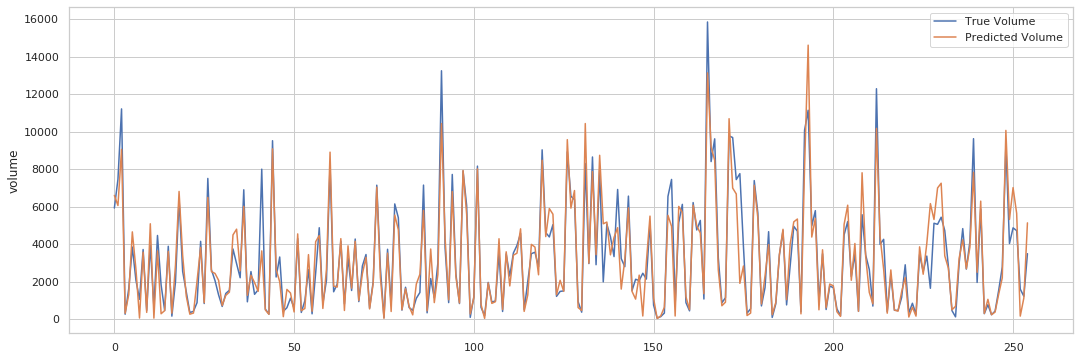

In [23]:
f = plt.figure(figsize=(18, 6))
sns.set(style="whitegrid")
sns.lineplot(x=range(len(y_pred)), y=y_pred, label='True Volume')
sns.lineplot(x=range(len(y_pred)), y=y_test, label='Predicted Volume')

Видно, что график предсказанных значений довольно неплохо повторяет истинные значения.

Посмотрим также на распределение остатков.

/home/gleb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


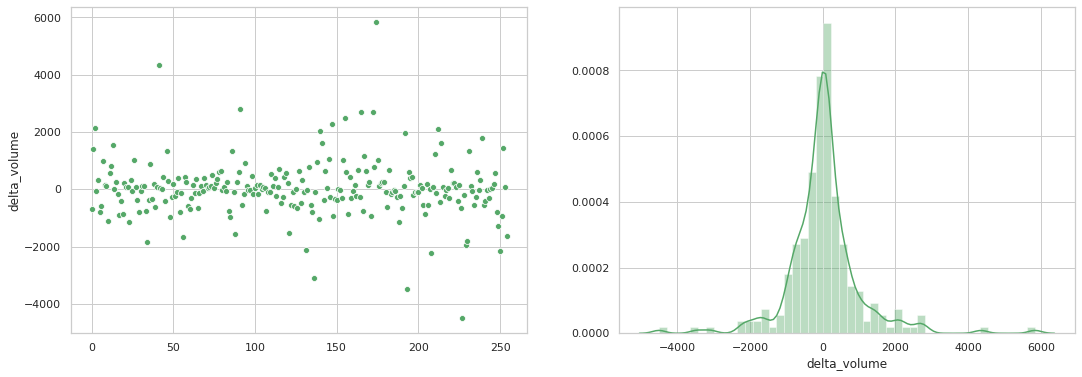

In [24]:
fig, ax =plt.subplots(1,2, figsize=(18, 6))
sns.scatterplot(x=range(len(y_pred)), y=(y_pred-y_test.rename('delta_volume')), color="g",ax=ax[0])
sns.distplot((y_pred-y_test.rename('delta_volume')), color='g', ax=ax[1])
fig.show()

In [25]:
print("Заметим, что распределение объемов продаж близко к нормальному со средним значением %.2f и стандартным отклонением %.2f"\
      %((y_pred-y_test).mean(), (y_pred-y_test).std()))

Заметим, что распределение объемов продаж близко к нормальному со средним значением 32.89 и стандартным отклонением 999.49


Посмотрим на **топ 10 важных критериев** для нашей модели.

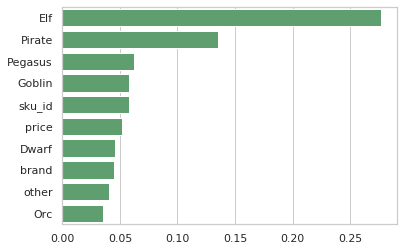

In [26]:
importances = pd.DataFrame(data=xgb_best.feature_importances_).T
importances.columns=X_to_pred.columns
sns.barplot(data=importances.sort_values(by=0, axis=1, ascending=False).iloc[:, :10], orient='h', color='g')

Видим, что цена идет на шестом месте по важности. И ее важность составляет:

In [27]:
print('важность цены %.1f%%' %(importances.price*100))

важность цены 5.2%


## Подготовим ответ для превого задания

In [28]:
def decode(DataFrame):
    for i in DataFrame:
        if i in category_dictionary:
            DataFrame[i] = DataFrame[i].map(lambda x: category_dictionary[i][x])

In [29]:
answer = X_to_pred[['month_n', 'ira', 'sku_id', 'price']].reset_index(drop=True)

In [30]:
decode(answer)

In [31]:
answer['year'] = answer.month_n // 12 + 2017

In [32]:
answer['month'] = answer.month_n - 24

In [33]:
answer['location'] = answer.ira.map(lambda x: locations[x])

In [34]:
answer = answer[['year', 'month', 'location', 'sku_id', 'price']]

In [35]:
answer.price *= price_std
answer.price += price_mean

In [36]:
answer['volume'] = xgb_best.predict(X_to_pred)
answer['revenue'] = answer.price * answer.volume

In [37]:
answer

,year,month,location,sku_id,price,volume,revenue
0,2019,7,Alpha City,sku #79,1.276421,15627.979492,19947.875347
1,2019,7,Alpha City,sku #106,1.339091,4143.246582,5548.183532
2,2019,7,Alpha City,sku #15,1.339091,16937.308594,22680.594736
3,2019,7,Alpha City,sku #16,3.414728,8817.326172,30108.772833
4,2019,7,Alpha City,sku #22,2.412005,17023.648438,41061.122863
...,...,...,...,...,...,...,...
169,2019,9,Pirate Bay,sku #78,1.354132,527.727600,714.612666
170,2019,9,Pirate Bay,sku #100,1.316530,1415.136719,1863.069322
171,2019,9,Pirate Bay,sku #76,1.316530,3310.286133,4358.089547
172,2019,9,Pirate Bay,sku #77,1.316530,3657.824707,4815.634354


**Запишем ответ в .tsv файл.**

In [38]:
answer.drop(columns=['price', 'revenue']).to_csv('Answer_volume.tsv', sep='\t', index=False)

## Решим вотрую задачу

Подберем для каждого товара в каждом регионе цену, позволяющую получить наибольшую выручку.

К сожалению, у нас нет явной функциональной зависимости между ценой и объемом продаж, поэтому задачу придется решать перебором.

Для каждого товара в каждом регионе разобьем диапазон 85% - 115% цены на 1000 точек, для каждой сделаем отдельное предсказание нашей моделью и найдем такую цену, которая обеспецивает максимальную выручку.

In [39]:
x = X_to_pred.reset_index(drop=True).copy()

best_revenues = answer.revenue.copy()
best_prices = (x.price.copy() * price_std + price_mean)
best_volumes = answer.volume.copy()

initial_price = (x.price.copy() * price_std + price_mean)

for k in np.linspace(0.85, 1.15, 1000):
    
    price = k * initial_price
    x.price = (price - price_mean) / price_std
    
    new_volume = xgb_best.predict(x)
    new_revenue = (new_volume * price)
      
    best_prices = (new_revenue > best_revenues) * price +\
                  (new_revenue <= best_revenues) * best_prices
    
    best_volumes = (new_revenue > best_revenues) * new_volume +\
                   (new_revenue <= best_revenues) * best_volumes
    
    best_revenues = best_prices * best_volumes
    
    
    

In [40]:
answer['new_price'] = best_prices
answer['new_volume'] = best_volumes
answer['best_revenue'] = best_revenues

In [41]:
answer

,year,month,location,sku_id,price,volume,revenue,new_price,new_volume,best_revenue
0,2019,7,Alpha City,sku #79,1.276421,15627.979492,19947.875347,1.467884,15114.247070,22185.957191
1,2019,7,Alpha City,sku #106,1.339091,4143.246582,5548.183532,1.539954,4144.186035,6381.857777
2,2019,7,Alpha City,sku #15,1.339091,16937.308594,22680.594736,1.346530,16937.308594,22806.598040
3,2019,7,Alpha City,sku #16,3.414728,8817.326172,30108.772833,3.926937,8817.241211,34624.755121
4,2019,7,Alpha City,sku #22,2.412005,17023.648438,41061.122863,2.308064,21221.423828,48980.406817
...,...,...,...,...,...,...,...,...,...,...
169,2019,9,Pirate Bay,sku #78,1.354132,527.727600,714.612666,1.283579,627.753906,805.771468
170,2019,9,Pirate Bay,sku #100,1.316530,1415.136719,1863.069322,1.514009,1369.723877,2073.774270
171,2019,9,Pirate Bay,sku #76,1.316530,3310.286133,4358.089547,1.514009,3467.655762,5250.062013
172,2019,9,Pirate Bay,sku #77,1.316530,3657.824707,4815.634354,1.514009,3754.447998,5684.268038


**Убедимся, что выручка во всех примерах выросла.**

In [42]:
(answer.best_revenue > answer.revenue).sum()

174

In [43]:
print('Цена товара была увеличена в %.1f%% случаев' %((answer.new_price > answer.price).sum()/174*100))

Цена товара была увеличена в 70.7% случаев


In [44]:
print('Объем продаж был увеличен в %.1f%% случаев' %((answer.new_volume > answer.volume).sum()/174*100))

Объем продаж был увеличен в 58.6% случаев


Интересно заметить, что имеются такие случаи, когда увеличение цены ведет к увеличению предсказываемого объема продаж, что не совсем вяжется с логикой.

**Посмотрим на суммарное увеличение выручки.**

In [45]:
print('Выручка без изменения цены %.f' %answer.revenue.sum())

Выручка без изменения цены 1351308


In [46]:
print('Выручка с изменением цены %.f' %answer.best_revenue.sum())

Выручка с изменением цены 1562484


In [47]:
print('Изменение составляет %.2f%%' %(100*(answer.best_revenue.sum()-answer.revenue.sum())/answer.revenue.sum()))

Изменение составляет 15.63%


## Теперь нужно убедиться, что рост выручки получен не случайно

In [48]:
print('Среднее абсолютное относительное изменение выручки составляет %.3f%%'\
      %(abs(answer.best_revenue - answer.revenue)/answer.revenue*100).mean())

Среднее абсолютное относительное изменение выручки составляет 23.922%


А теперь уберем отсюда "абсолютное"

In [49]:
print('Среднее относительное изменение выручки составляет %.3f%%'\
      %((answer.best_revenue - answer.revenue)/answer.revenue*100).mean())

Среднее относительное изменение выручки составляет 23.922%


Равенство полученных значений говорит нам о том, что во всех случаях выручка растет и растет в среднем на приведенное выше количество процентов.

**Для еще большей уверенности, подойдем к этому вопросу с точки зрения статистики.**

Попытаемся воспользоваться t-тестом, где нулеваяя гипотеза - отличия в выручке получились случайно. 

Для этого неопходима гомогенность дисперсий. Проверить ее нам поможет тест Левена:

In [50]:
import scipy.stats as stats

In [51]:
stats.levene(answer.best_revenue, answer.revenue)

LeveneResult(statistic=0.9548886972379803, pvalue=0.3291607540830277)

Как видим, p-уровень значимости = 0.33, значит условие гомогенности дисперсий выполняется.

Не смотря на то, что для больших выборок (больше 30 наблюдений) нормальность распределений перестает быть необходимым условием качественного t-теста, посмотрим на распределения выручек до и после изменения цен.

/home/gleb/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


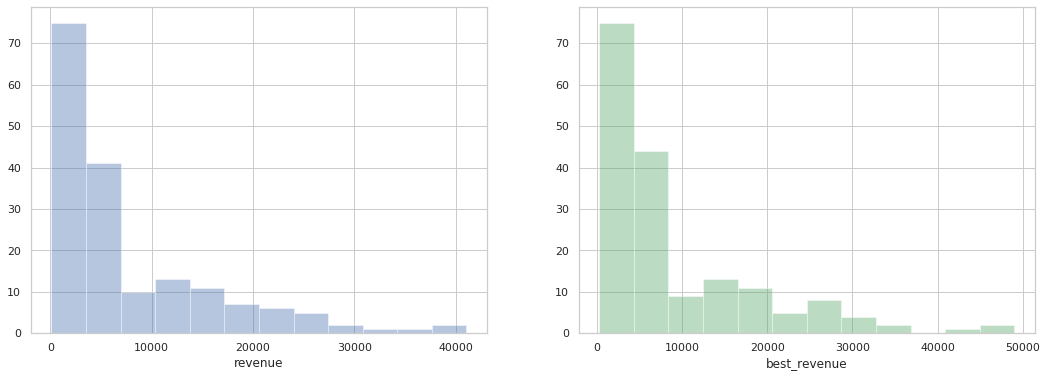

In [52]:
fig, ax =plt.subplots(1,2, figsize=(18, 6))
sns.distplot(answer.revenue, color='b', ax=ax[0], kde=False)
sns.distplot(answer.best_revenue, color='g', ax=ax[1], kde=False)
fig.show()

Как и ожидалось, они не нормальные.

Проведем t-тест.

In [53]:
print('Вероятность получить такое же или еще большее отличие при условии, что верна нулевая гипотеза p_value = %.1e'\
%stats.ttest_rel(answer.best_revenue, answer.revenue)[1])

Вероятность получить такое же или еще большее отличие при условии, что верна нулевая гипотеза p_value = 1.6e-16


Что позволяет нам смело откинуть предположение о том, что рост выручки получен случайно.